# Task 2 : Generative models (VAE and GAN)

For this task, we will use the FashionMNIST dataset. Note : While the code is wrtten from scratch, certain parts are auto-completed through Colab/Tab-Nine completions.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

First, we'll implement a simple VAE model. 

In [2]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=400, z_dim=20): # final 20 dimensions for the latent space
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_channels * 28 * 28, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, z_dim * 2)  # 2 for mean and log variance.
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_channels * 28 * 28),
            nn.Sigmoid()  # Output between [0, 1]
        )

    def reparameterize(self, mu, log_var): # Reparameterization trick
        std = log_var.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1) # Split into mu and log_var
        z = self.reparameterize(mu, log_var)
        x_reconstruct = self.decoder(z)
        return x_reconstruct, mu, log_var

We'll use the pytorch methods itself to download the data-sets.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [14]:
model = VAE()
model.to(device)
criterion = nn.BCELoss(reduction='sum') # Loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(data)
        loss = criterion(reconstruction, data.view(-1, 784)) 
        # KL divergence
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss += kl_divergence
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(train_loader.dataset)

# Validation
def validate(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstruction, mu, log_var = model(data)
            loss = criterion(reconstruction, data.view(-1, 784))
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            test_loss += loss.item() + kl_divergence.item()
    return test_loss / len(test_loader.dataset)

Epoch 0, Train Loss: 284.6288, Test Loss: 262.3507
Epoch 1, Train Loss: 255.8820, Test Loss: 254.5961
Epoch 2, Train Loss: 250.3010, Test Loss: 251.2731
Epoch 3, Train Loss: 247.6062, Test Loss: 248.2992
Epoch 4, Train Loss: 245.9296, Test Loss: 246.9600
Epoch 5, Train Loss: 244.9123, Test Loss: 246.2125
Epoch 6, Train Loss: 244.0725, Test Loss: 246.0897
Epoch 7, Train Loss: 243.4585, Test Loss: 245.0558
Epoch 8, Train Loss: 242.9212, Test Loss: 244.6846
Epoch 9, Train Loss: 242.5345, Test Loss: 244.3126


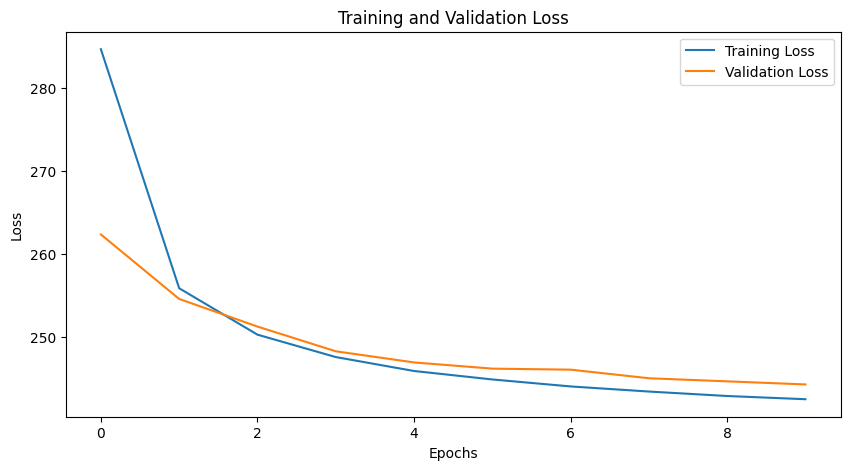

In [15]:
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = train(epoch)
    test_loss = validate(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

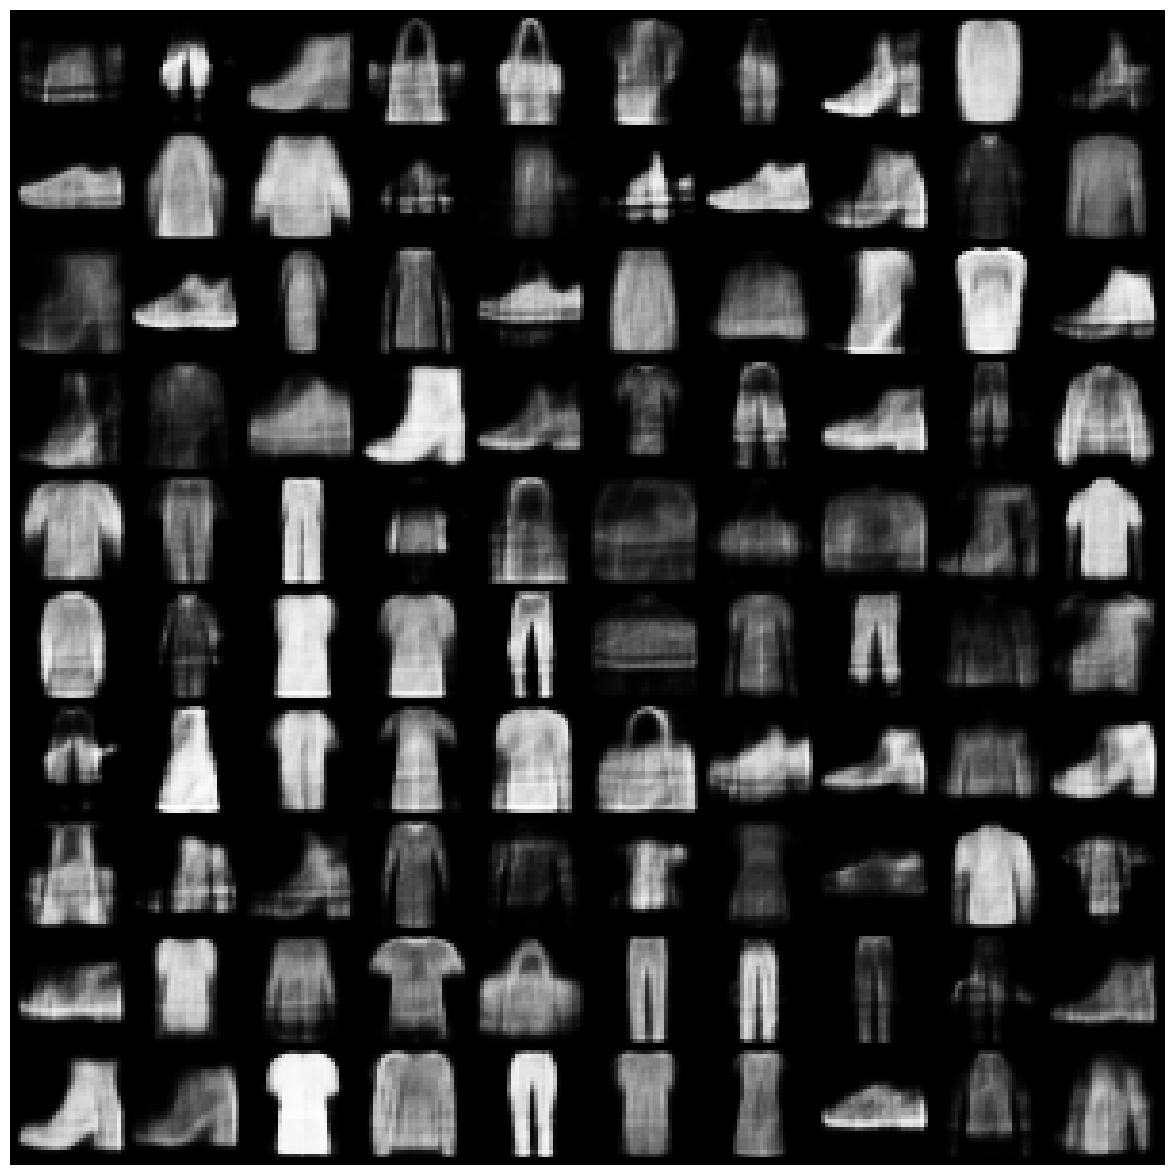

In [19]:
z_dim = 20
random_latent_vectors = torch.randn(100, z_dim).to(device) # generate 100 random points in the latent space

with torch.no_grad():
    model.eval()
    generated_images = model.decoder(random_latent_vectors).view(-1, 1, 28, 28) # get the generated images

grid = make_grid(generated_images, nrow=10) # make a grid of those
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

Images look good enough for just 10 epochs of training. We can clearly notice the distinct clothes generated from the altent space.
---
## Part 2: GAN
Next, we'll implement a simple GAN.

In [20]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        ) # Output between [-1, 1]

    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ) # Output between [0, 1]

    def forward(self, x):
        return self.fc(x)

class GAN(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(GAN, self).__init__()
        self.generator = Generator(z_dim, img_dim)
        self.discriminator = Discriminator(img_dim)

In [21]:
z_dim = 100  # generator input
learning_rate = 0.0002 # learning rate
batch_size = 128 # size of the batches
img_dim = 28*28  # size of the Fashion-MNIST images (flattened)
epochs = 50 # number of epochs

# Loss function
criterion = nn.BCELoss() # Binary Cross Entropy Loss

gan = GAN(z_dim, img_dim)
gan.to(device)

# Optimizers
optimizer_gen = optim.Adam(gan.generator.parameters(), lr=learning_rate)
optimizer_disc = optim.Adam(gan.discriminator.parameters(), lr=learning_rate)

In [22]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [23]:
gen_losses = []
disc_losses = []

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.view(-1, 784).to(device)  # Flatten the batch of real images from the dataset
        batch_size = real.size(0)

        ### Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        gan.discriminator.zero_grad()
        # Real images
        real_labels = torch.ones(batch_size, 1).to(device)
        loss_disc_real = criterion(gan.discriminator(real), real_labels)
        # Fake images
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gan.generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        loss_disc_fake = criterion(gan.discriminator(fake.detach()), fake_labels)
        # Total discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        loss_disc.backward()
        optimizer_disc.step()

        ### Generator: minimize log(1 - D(G(z))) <=> maximize log(D(G(z))
        gan.generator.zero_grad()
        # Fake images are already generated
        loss_gen = criterion(gan.discriminator(fake), real_labels)  # We want the fake to be seen as real
        loss_gen.backward()
        optimizer_gen.step()

        if batch_idx == len(train_loader)-1:  # Print the progress and save losses for the last batch
            print(f'Epoch [{epoch+1}/{epochs}]  Loss D: {loss_disc.item():.4f}, loss G: {loss_gen.item():.4f}')
            gen_losses.append(loss_gen.item())
            disc_losses.append(loss_disc.item())

Epoch [1/50]  Loss D: 0.1577, loss G: 4.3448
Epoch [2/50]  Loss D: 0.5022, loss G: 2.6803
Epoch [3/50]  Loss D: 0.2593, loss G: 2.3520
Epoch [4/50]  Loss D: 0.3789, loss G: 2.7598
Epoch [5/50]  Loss D: 0.2096, loss G: 3.5633
Epoch [6/50]  Loss D: 0.2666, loss G: 3.4912
Epoch [7/50]  Loss D: 0.2486, loss G: 2.7155
Epoch [8/50]  Loss D: 0.2099, loss G: 3.2042
Epoch [9/50]  Loss D: 0.3884, loss G: 2.3432
Epoch [10/50]  Loss D: 0.3040, loss G: 2.7730
Epoch [11/50]  Loss D: 0.3018, loss G: 2.0570
Epoch [12/50]  Loss D: 0.3978, loss G: 2.3324
Epoch [13/50]  Loss D: 0.3360, loss G: 2.0956
Epoch [14/50]  Loss D: 0.4292, loss G: 1.9955
Epoch [15/50]  Loss D: 0.3161, loss G: 1.9154
Epoch [16/50]  Loss D: 0.3151, loss G: 1.5853
Epoch [17/50]  Loss D: 0.3382, loss G: 2.0232
Epoch [18/50]  Loss D: 0.3768, loss G: 1.9672
Epoch [19/50]  Loss D: 0.4727, loss G: 1.5114
Epoch [20/50]  Loss D: 0.5361, loss G: 1.3165
Epoch [21/50]  Loss D: 0.3693, loss G: 2.0139
Epoch [22/50]  Loss D: 0.3674, loss G: 1.77

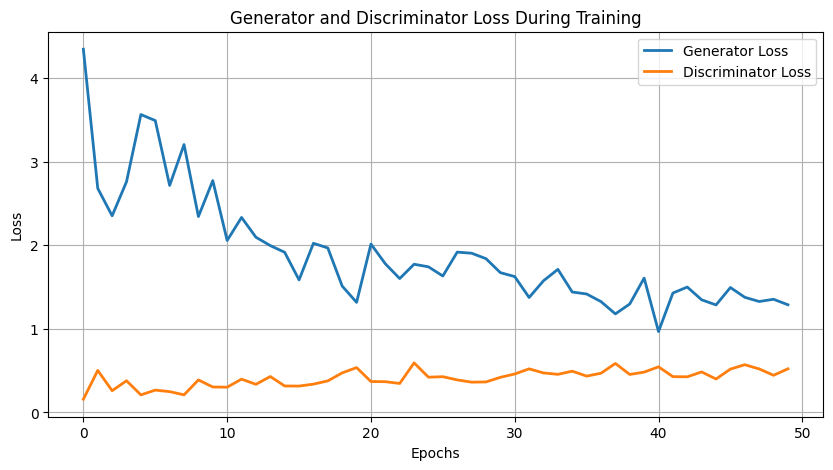

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss', linewidth=2)
plt.plot(disc_losses, label='Discriminator Loss', linewidth=2)
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def generate_noise(number_of_images, z_dim):
    return torch.randn(number_of_images, z_dim).to(device)

z_dim = 100 # random noise
noise = generate_noise(100, z_dim)  # 100 images

gan.generator.eval()
with torch.no_grad():
    fake_images = gan.generator(noise).view(-1, 1, 28, 28)  # images from the noise using the generator. reshape to (N, C, H, W) format

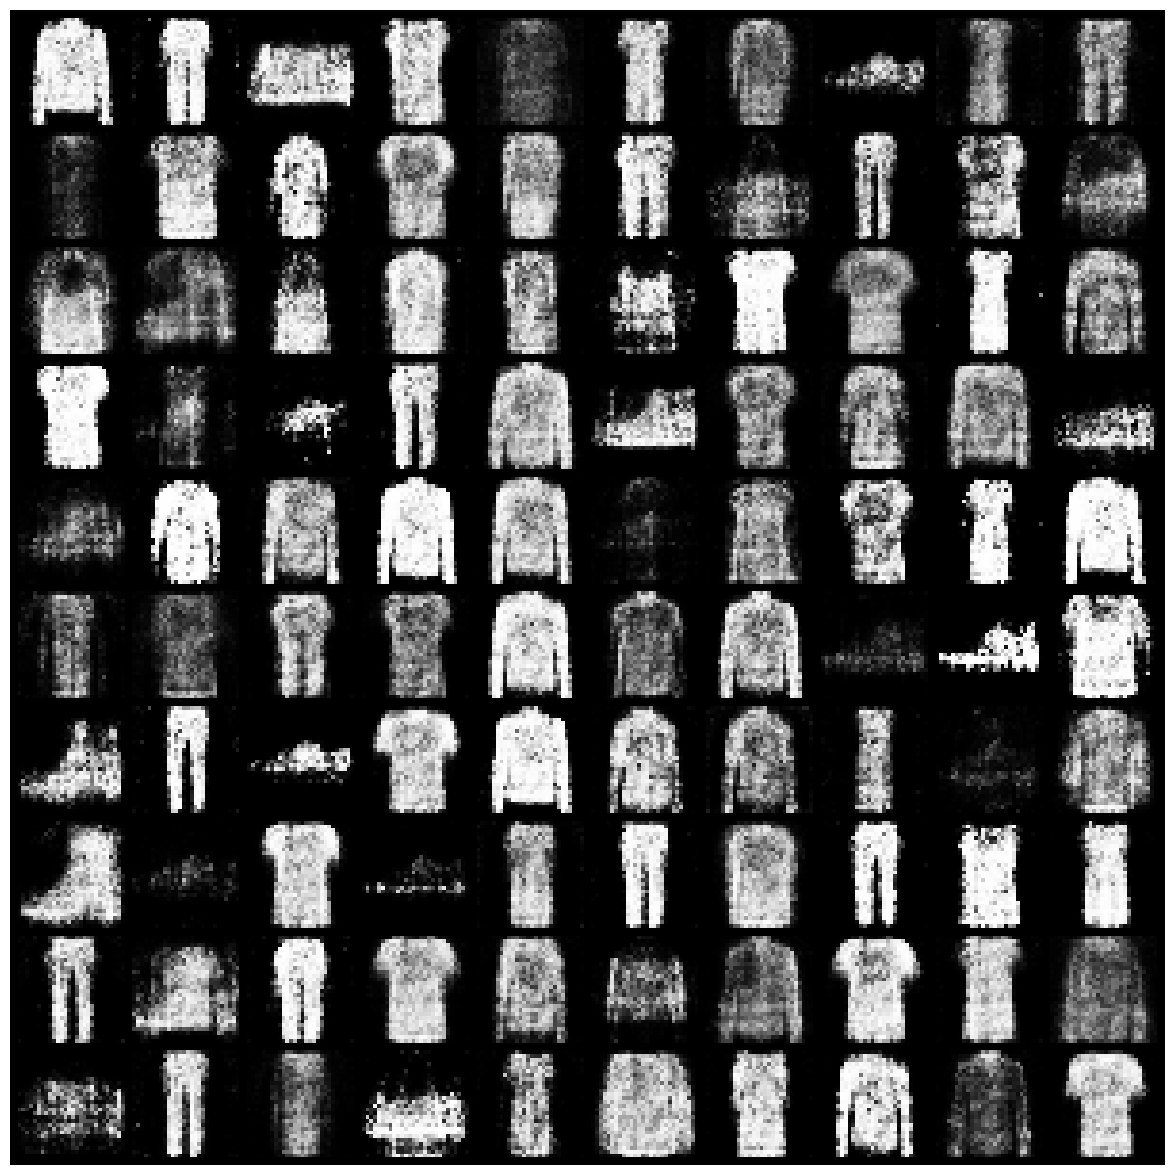

In [25]:
grid = make_grid(fake_images, nrow=10, normalize=True)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)), interpolation='nearest')
plt.axis('off')
plt.show()
